In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.signal as signal
from scipy import cluster
from Bio import SeqIO
from Bio.Seq import Seq, MutableSeq 
from Bio.SeqUtils import GC  
import random
from SCvariables import *
%matplotlib inline

sns.set_style('white')
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

In [2]:
genome_folder = './data/scer/'
genomefasta = {}
for i in range(1,10):
    x = loading_fasta_gbk(genome_folder + 'chr0{}.fsa'.format(i),'fasta')
    genomefasta[x.name] = x
for i in range(10,17):
    x = loading_fasta_gbk(genome_folder + 'chr{}.fsa'.format(i),'fasta')
    genomefasta[x.name] = x

chr_lengths = pd.read_csv(genome_folder + 'scer.genome',sep = '\t',header=None)
chr_lengths.columns = ['chromosome','length']

yeastgenome = {}
chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']
for i in range(1,10):
    x = loading_fasta_gbk(genome_folder + 'chr0{}.gb'.format(i),'genbank')
    yeastgenome['chr'+chroms[i-1]] = reading_gbk_new(x,['CDS','tRNA','rRNA','ncRNA'])
for i in range(10,17):
    x = loading_fasta_gbk(genome_folder + 'chr{}.gb'.format(i),'genbank')
    yeastgenome['chr'+chroms[i-1]] = reading_gbk_new(x,['CDS','tRNA','rRNA','ncRNA'])


##yeastgenome representation puts a 1 where there is a gene
yeastgenome_gene_representation = {}
for key, val in iter(yeastgenome.items()):
    x = np.zeros([1,len(genomefasta[key].seq)])
    for genes in [val]:
        for i in range (0, len(genes.annotation)):
            if genes.strand[i]== +1:
                for j in range(0, genes.length[i]-1):
                    x[0][genes.start[i]+j]=10
            else:
                for j in range(0,genes.length[i]-1):
                    x[0][genes.end[i]+j]=-10
    yeastgenome_gene_representation[key] = x
    
#convert into a pandas...
genomedict = {}
chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']
for c in chroms:
    chrom = 'chr'+c
    name,start,end,strand=[],[],[],[]
    for j in range(len(yeastgenome[chrom].start)):
        name.append(yeastgenome[chrom].name[j])
        start.append(yeastgenome[chrom].start[j])
        end.append(yeastgenome[chrom].end[j])
        strand.append(yeastgenome[chrom].strand[j])
    genomedict[chrom] = pd.DataFrame([name,start,end,strand],['name','start','end','strand']).transpose()
    
#calculate AT content
sliding_100 = {}
for key, val in iter(genomefasta.items()):
    sliding_100[key] = sliding_window(val,100)[0]
    
genomedict = formatGenomeDict(genomedict,genomefasta)

catyeastgenome = genomefasta['chrI'].seq
for chrom in chroms[1:]:
    catyeastgenome = catyeastgenome + genomefasta['chr'+chrom].seq

In [3]:
RNAseq = loadyeastRNAseqData() #raff data
RNAseqaF = loadyeastRNAseqaFData() #aF arrest data
RNAseqgly = loadyeastGlyRNAseqData() #glycerol data
RNAseq_RPKM = pd.read_csv('./data/RNAseq_rpkm_merged.txt',sep=',')

downloading GSM5001907_D20-252008_nodup_plus_all.txt.gz from GEO
unzipping GSM5001907_D20-252008_nodup_plus_all.txt.gz


/home/msguo/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


downloading GSM5001907_D20-252008_nodup_minus_all.txt.gz from GEO
unzipping GSM5001907_D20-252008_nodup_minus_all.txt.gz
downloading GSM5001909_D20-252007_nodup_plus_all.txt.gz from GEO
unzipping GSM5001909_D20-252007_nodup_plus_all.txt.gz
downloading GSM5001909_D20-252007_nodup_minus_all.txt.gz from GEO
unzipping GSM5001909_D20-252007_nodup_minus_all.txt.gz
downloading GSM5001911_D20-3448_plus_all.txt.gz from GEO
unzipping GSM5001911_D20-3448_plus_all.txt.gz
downloading GSM5001911_D20-3448_minus_all.txt.gz from GEO
unzipping GSM5001911_D20-3448_minus_all.txt.gz


In [4]:
GapR_raff = loadraffChIP()
GapR_raffneg = loadraffnegChIP()
GapR_raffINP = loadraffINP()
chip_fold = loadChIPFold(GapR_raff, GapR_raffneg)

downloading GSM5001899_D20-5952_all_nodup.txt.gz from GEO
unzipping GSM5001899_D20-5952_all_nodup.txt.gz
downloading GSM5001905_D20-261001_all_nodup.txt.gz from GEO
unzipping GSM5001905_D20-261001_all_nodup.txt.gz
downloading GSM5001903_D20-6528_all_nodup.txt.gz from GEO
unzipping GSM5001903_D20-6528_all_nodup.txt.gz


In [5]:
GapR_raffaF = loadraffaFChIP()
GapR_raffnegaF = loadaFnegChIP()
GapR_raffINPaF = loadraffaFINP()
chip_foldaF = loadChIPFold(GapR_raffaF, GapR_raffnegaF)

downloading GSM5001901_D20-5954_all_nodup.txt.gz from GEO
unzipping GSM5001901_D20-5954_all_nodup.txt.gz
downloading GSM5001906_D20-261002_all_nodup.txt.gz from GEO
unzipping GSM5001906_D20-261002_all_nodup.txt.gz
downloading GSM5001904_D20-6530_all_nodup.txt.gz from GEO
unzipping GSM5001904_D20-6530_all_nodup.txt.gz


In [6]:
GapR_gly = loadglyChIP()
GapR_neggly = loadglynegChIP()
chip_foldgly = loadChIPFold(GapR_gly, GapR_neggly)

downloading GSM4628318_D19_5482_all.txt.gz from GEO
unzipping GSM4628318_D19_5482_all.txt.gz
downloading GSM4628316_D19_5480_all.txt.gz from GEO
unzipping GSM4628316_D19_5480_all.txt.gz


In [7]:
chip_fold['fold_nolog_nosmooth'] = ((GapR_raff.val_norm_no12+0.01)/(GapR_raffneg.val_norm_no12+0.01))
chip_foldaF['fold_nolog_nosmooth'] = ((GapR_raffaF.val_norm_no12+0.01)/(GapR_raffnegaF.val_norm_no12+0.01))
chip_foldgly['fold_nolog_nosmooth'] = ((GapR_gly.val_norm_no12+0.01)/(GapR_neggly.val_norm_no12+0.01))

In [8]:
#S1-DRIP-seq analyzed from SRR3504389.sra (wildtype-rep1) and SRR3504396.sra (wildtype-total)
DRIP_wt = pd.read_csv('./data/SRR3504389_all.txt',sep = ',', index_col=0)
DRIP_wt_total = pd.read_csv('./data/SRR3504396_all.txt',sep = ',', index_col=0) 
DRIP_fold = DRIP_wt.copy()
DRIP_fold['fold'] = np.log2((DRIP_wt.val_norm+0.01)/(DRIP_wt_total.val_norm+0.01))
DRIP_fold['fold_nolog'] = ((DRIP_wt.val_norm+0.01)/(DRIP_wt_total.val_norm+0.01))

### Fig. 7A and supplemental 1A

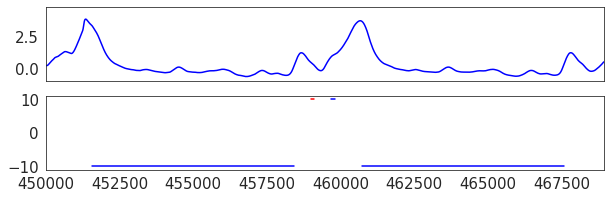

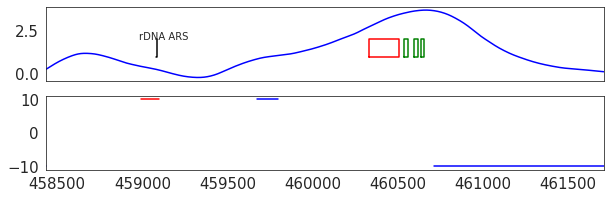

In [9]:
#Fig 7A, rDNA locus
start = 450000 #451418 is the left junction
end = 468929# is the right junction
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,3), sharey=False)
axes[0].plot(np.arange(start, end),np.log2(chip_foldgly[chip_foldgly.chr=='chrXII'].fold_nolog[start:end]), 'blue')

axes[1].plot([451575, 458432], [-10,-10],'b')
axes[1].plot([458991, 459097], [10,10],'r')
axes[1].plot([459676, 459796], [10,10],'b')
axes[1].plot([460712, 467569], [-10,-10],'b')

axes[0].get_xaxis().set_visible(False)
axes[0].set_xlim([start,end])
axes[0].set_ylim([-1,4.8])
axes[1].set_xlim([start,end])

#Fig 7A, rDNA locus, blowup
start = 458433 #is the position of NTS2-1
end = 461712 #460712# is the position at end of 35S
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,3), sharey=False)
axes[0].plot(np.arange(start, end),np.log2(chip_foldgly[chip_foldgly.chr=='chrXII'].fold_nolog[start:end]), 'blue')

axes[0].plot([459078,459088,459088,459078,459078],[1,1,2,2,2],'k')#rDNA ARS
axes[0].text(458978,2,'rDNA ARS')

#label the RFB
m=regex.search('AAACTTATACAAGCACTCATGTTT',str(genomefasta['chrXII'].seq)) #RFB1
axes[0].plot([m.span()[0],m.span()[1],m.span()[1],m.span()[0],m.span()[0]],[1,1,2,2,1],'g')
#axes[0].text(m.span()[0]-100,20,'RFB-1')
m=regex.finditer('GCAAACTGTCCGGGCAAATC',str(genomefasta['chrXII'].seq)) #RFB2 #use second one...
axes[0].plot([460599,460619,460619,460599,460599],[1,1,2,2,1],'g')
#axes[0].text(460599-100,110,'RFB-2')
m=regex.search('CTTTGTGAAAGCCCTTCTCTT',str(genomefasta['chrXII'].seq)) #RFB3 #use second one...
axes[0].plot([460636,460657,460657,460636,460636],[1,1,2,2,1],'g')
#axes[0].text(460636-100,20,'RFB-3')
m=regex.search('CCCATCTTTGCAACGAAAAA',str(genomefasta['chrXII'].seq)) #RFB3 #use second one...
axes[0].plot([460335,460507,460507,460335,460335],[1,1,2,2,1],'r')
#axes[0].text(460636-100,20,'RFB-3')

axes[0].get_xaxis().set_visible(False)
axes[0].set_xlim([start,end])
axes[1].set_xlim([start,end])

axes[1].plot([451575, 458432], [-10,-10],'b')
axes[1].plot([458991, 459097], [10,10],'r')
axes[1].plot([459676, 459796], [10,10],'b')
axes[1].plot([460712, 467569], [-10,-10],'b')

(450000, 468929)

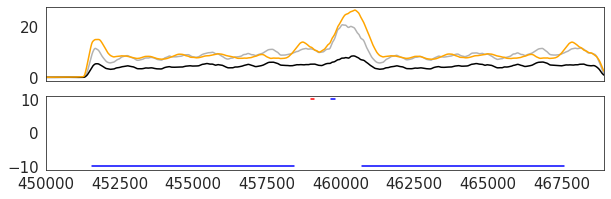

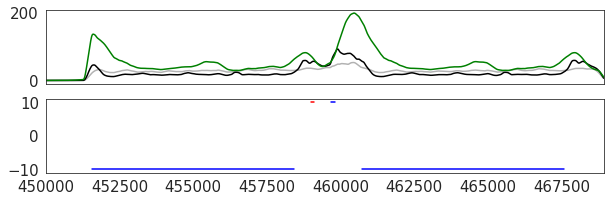

In [10]:
#Fig S7A, rDNA locus, vs inputs
start = 450000 #451418 is the left junction
end = 468929# is the right junction
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,3), sharey=False)
axes[0].plot(np.arange(start, end),GapR_raffneg[GapR_raffneg.chr=='chrXII'].smooth[start:end], 'black',alpha=0.3)
axes[0].plot(np.arange(start, end),GapR_raffINP[GapR_raffINP.chr=='chrXII'].smooth[start:end], 'black')
axes[0].plot(np.arange(start, end),GapR_raff[GapR_raff.chr=='chrXII'].smooth[start:end], 'orange')

axes[1].plot([451575, 458432], [-10,-10],'b')
axes[1].plot([458991, 459097], [10,10],'r')
axes[1].plot([459676, 459796], [10,10],'b')
axes[1].plot([460712, 467569], [-10,-10],'b')

axes[0].get_xaxis().set_visible(False)
axes[0].set_xlim([start,end])
axes[1].set_xlim([start,end])

#Fig S7A, rDNA locus, vs inputs
start = 450000 #451418 is the left junction
end = 468929# is the right junction
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,3), sharey=False)
axes[0].plot(np.arange(start, end),GapR_raffnegaF[GapR_raffnegaF.chr=='chrXII'].smooth[start:end], 'black',alpha=0.3)
axes[0].plot(np.arange(start, end),GapR_raffINPaF[GapR_raffINPaF.chr=='chrXII'].smooth[start:end], 'black')
axes[0].plot(np.arange(start, end),GapR_raffaF[GapR_raffaF.chr=='chrXII'].smooth[start:end], 'green')

axes[1].plot([451575, 458432], [-10,-10],'b')
axes[1].plot([458991, 459097], [10,10],'r')
axes[1].plot([459676, 459796], [10,10],'b')
axes[1].plot([460712, 467569], [-10,-10],'b')

axes[0].get_xaxis().set_visible(False)
axes[0].set_xlim([start,end])
axes[1].set_xlim([start,end])

### Fig. 7B

In [11]:
#import and parse list of ty elements
ty_list = pd.read_csv('./data/Scer3_ty.txt',sep = ' ',header=None)
ty_list.columns = ['names',1,2,3,4,'strand']
ty_list['chr'] = 'chr'+ty_list[3]
a = []
[a.append(int(str.split(i,'..')[0])) for i in ty_list[4].values]
ty_list['start'] = a
a = []
[a.append(int(str.split(i,'..')[1])) for i in ty_list[4].values]
ty_list['end'] = a
ty_list.drop(columns=[1,2,3,4],inplace=True)

#drop YCLWTy5-1 b/c too close to end, everything else is fine
ty_list.drop(19,inplace=True)

Text(0.5, 0, 'YBLWTy2-1')

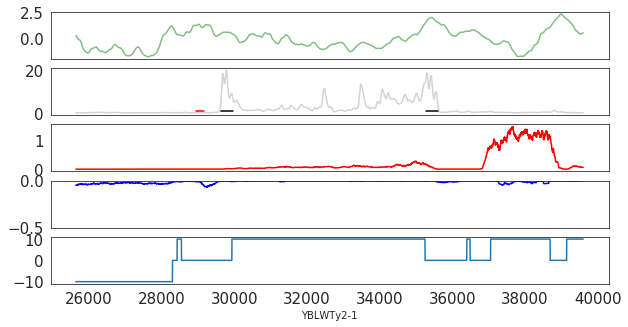

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,5),sharey=False)
i = 48
chrom = ty_list.iloc[i].chr
startplot=ty_list.iloc[i].start-4000
endplot=ty_list.iloc[i].end+4000
axes[0].plot(np.arange(startplot, endplot), np.log2(chip_foldaF[chip_foldaF.chr==chrom].fold_nolog[startplot:endplot]), 'green',alpha = 0.5)
axes[1].plot(np.arange(startplot, endplot), DRIP_fold[DRIP_fold.chr==chrom].fold_nolog[startplot:endplot], 'darkgrey',alpha = 0.5)
axes[1].plot([28942,29160],[1,1],'r')
axes[1].plot([29644,29975],[1,1],'k')
axes[1].plot([35271,35602],[1,1],'k')
axes[2].plot(np.arange(startplot, endplot),(RNAseqaF[RNAseqaF.chr==chrom].fwd[startplot:endplot]),'red')
axes[3].plot(np.arange(startplot, endplot),-(RNAseqaF[RNAseqaF.chr==chrom].rev[startplot:endplot]),'blue')

axes[3].set_ylim([-0.5,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)

axes[4].plot(np.arange(startplot,endplot), yeastgenome_gene_representation[chrom][0,startplot:endplot])
axes[4].set_xlabel(ty_list.iloc[i].names)

### Fig. 7C and supplement 1E

In [13]:
DRIP_cumsum = {}
for chrom in chr_lengths.chromosome:
    DRIP_cumsum[chrom] = np.cumsum(DRIP_fold[DRIP_fold.chr==chrom].fold_nolog.values)

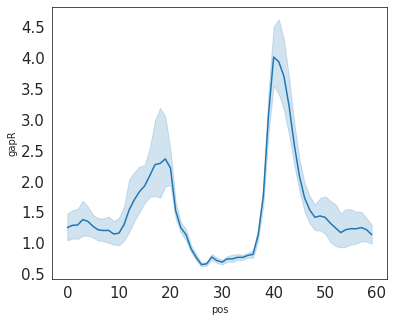

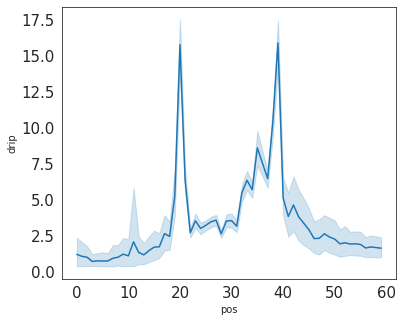

In [16]:
#GapR occupancy vs S1-DRIP-seq
gapR_fold_nolog_cumsum = calccumsum(chip_foldaF)

DRIP_occupancy = []
gapR_occupancy = []
bins = {}
for [names,strand,chrom,start,end] in ty_list.itertuples(index=False):
    l = end-start
    if strand == '+':
        x = np.arange(start,end,int(l/20))
        leftBin = np.arange(start-2000,start,100)
        rightBin = np.arange(end,end+2101,100)[1:]
        if len(x) == 20:
            x = np.arange(start,end,int(l/21))
        x[6:] = x[6:]+end-x[-1]
        combBins = np.concatenate((leftBin,x,rightBin))
        bins[names] = combBins
        a = np.zeros(60)
        c = np.zeros(60)
        for i in range(60):
            a[i]=(DRIP_cumsum[chrom][combBins[i+1]]-DRIP_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
            c[i]=(gapR_fold_nolog_cumsum[chrom][combBins[i+1]]-gapR_fold_nolog_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
        DRIP_occupancy.append(a)
        gapR_occupancy.append(c)

    if strand == '-':
        x = np.arange(start,end,int(l/20))
        leftBin = np.arange(start-2000,start,100)
        rightBin = np.arange(end,end+2101,100)[1:]
        if len(x) == 20:
            x = np.arange(start,end,int(l/21))
        x[6:] = x[6:]+end-x[-1]
        combBins = np.concatenate((leftBin,x,rightBin))
        bins[names] = combBins
        a = np.zeros(60)
        c = np.zeros(60)
        for i in range(60):
            a[i]=(DRIP_cumsum[chrom][combBins[i+1]]-DRIP_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
            c[i]=(gapR_fold_nolog_cumsum[chrom][combBins[i+1]]-gapR_fold_nolog_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
        DRIP_occupancy.append(a[::-1])
        gapR_occupancy.append(c[::-1])
    
drip_oc = np.asarray(DRIP_occupancy)
drip_avg = np.mean(drip_oc, axis = 0)
drip_avg_norm = drip_avg/np.max(drip_avg)
gapR_oc = np.asarray(gapR_occupancy)
gapR_avg = np.mean(gapR_oc, axis = 0)
gapR_avg_norm = gapR_avg/np.max(gapR_avg)

GapR_ty_matrix = pd.DataFrame([gapR_oc[0],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
GapR_ty_matrix['rep'] = 0
for i in range(1,len(gapR_oc)):
    t = pd.DataFrame([gapR_oc[i],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
    t['rep']=i
    GapR_ty_matrix = GapR_ty_matrix.append(t)
    
DRIP_ty_matrix = pd.DataFrame([drip_oc[0],np.arange(len(drip_oc[0]))],['drip','pos']).transpose()
DRIP_ty_matrix['rep'] = 0
for i in range(1,len(drip_oc)):
    t = pd.DataFrame([drip_oc[i],np.arange(len(drip_oc[0]))],['drip','pos']).transpose()
    t['rep']=i
    DRIP_ty_matrix = DRIP_ty_matrix.append(t)
    
plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="gapR", data=GapR_ty_matrix, ci=95)

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="drip", data=DRIP_ty_matrix, ci=95)

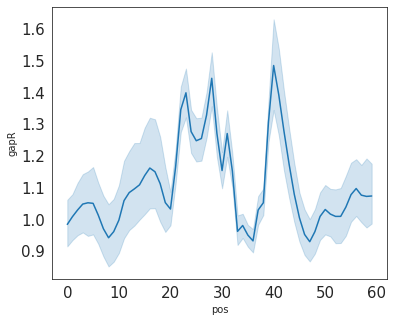

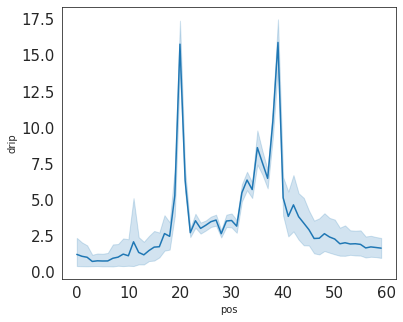

In [17]:
#GapR occupancy vs S1-DRIP-seq
gapR_fold_nolog_cumsum = calccumsum(chip_fold)

DRIP_occupancy = []
gapR_occupancy = []
bins = {}
for [names,strand,chrom,start,end] in ty_list.itertuples(index=False):
    l = end-start
    if strand == '+':
        x = np.arange(start,end,int(l/20))
        leftBin = np.arange(start-2000,start,100)
        rightBin = np.arange(end,end+2101,100)[1:]
        if len(x) == 20:
            x = np.arange(start,end,int(l/21))
        x[6:] = x[6:]+end-x[-1]
        combBins = np.concatenate((leftBin,x,rightBin))
        bins[names] = combBins
        a = np.zeros(60)
        c = np.zeros(60)
        for i in range(60):
            a[i]=(DRIP_cumsum[chrom][combBins[i+1]]-DRIP_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
            c[i]=(gapR_fold_nolog_cumsum[chrom][combBins[i+1]]-gapR_fold_nolog_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
        DRIP_occupancy.append(a)
        gapR_occupancy.append(c)

    if strand == '-':
        x = np.arange(start,end,int(l/20))
        leftBin = np.arange(start-2000,start,100)
        rightBin = np.arange(end,end+2101,100)[1:]
        if len(x) == 20:
            x = np.arange(start,end,int(l/21))
        x[6:] = x[6:]+end-x[-1]
        combBins = np.concatenate((leftBin,x,rightBin))
        bins[names] = combBins
        a = np.zeros(60)
        c = np.zeros(60)
        for i in range(60):
            a[i]=(DRIP_cumsum[chrom][combBins[i+1]]-DRIP_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
            c[i]=(gapR_fold_nolog_cumsum[chrom][combBins[i+1]]-gapR_fold_nolog_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
        DRIP_occupancy.append(a[::-1])
        gapR_occupancy.append(c[::-1])
    
drip_oc = np.asarray(DRIP_occupancy)
drip_avg = np.mean(drip_oc, axis = 0)
drip_avg_norm = drip_avg/np.max(drip_avg)
gapR_oc = np.asarray(gapR_occupancy)
gapR_avg = np.mean(gapR_oc, axis = 0)
gapR_avg_norm = gapR_avg/np.max(gapR_avg)

GapR_ty_matrix = pd.DataFrame([gapR_oc[0],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
GapR_ty_matrix['rep'] = 0
for i in range(1,len(gapR_oc)):
    t = pd.DataFrame([gapR_oc[i],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
    t['rep']=i
    GapR_ty_matrix = GapR_ty_matrix.append(t)
    
DRIP_ty_matrix = pd.DataFrame([drip_oc[0],np.arange(len(drip_oc[0]))],['drip','pos']).transpose()
DRIP_ty_matrix['rep'] = 0
for i in range(1,len(drip_oc)):
    t = pd.DataFrame([drip_oc[i],np.arange(len(drip_oc[0]))],['drip','pos']).transpose()
    t['rep']=i
    DRIP_ty_matrix = DRIP_ty_matrix.append(t)
    
plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="gapR", data=GapR_ty_matrix, ci=95)
#plt.ylim([0.3,4.8])

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="drip", data=DRIP_ty_matrix, ci=95)

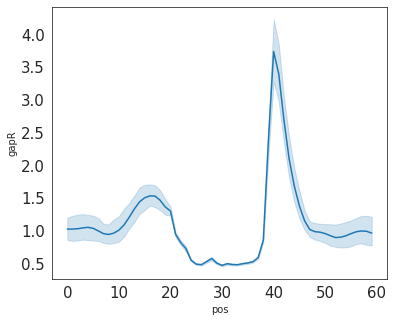

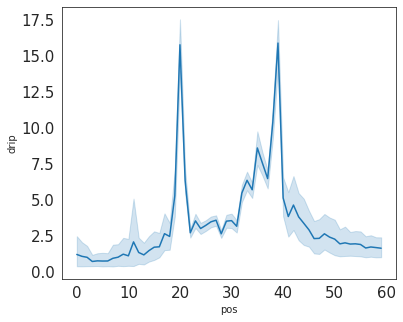

In [18]:
#GapR occupancy vs S1-DRIP-seq
gapR_fold_nolog_cumsum = calccumsum(chip_foldgly)

DRIP_occupancy = []
gapR_occupancy = []
bins = {}
for [names,strand,chrom,start,end] in ty_list.itertuples(index=False):
    l = end-start
    if strand == '+':
        x = np.arange(start,end,int(l/20))
        leftBin = np.arange(start-2000,start,100)
        rightBin = np.arange(end,end+2101,100)[1:]
        if len(x) == 20:
            x = np.arange(start,end,int(l/21))
        x[6:] = x[6:]+end-x[-1]
        combBins = np.concatenate((leftBin,x,rightBin))
        bins[names] = combBins
        a = np.zeros(60)
        c = np.zeros(60)
        for i in range(60):
            a[i]=(DRIP_cumsum[chrom][combBins[i+1]]-DRIP_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
            c[i]=(gapR_fold_nolog_cumsum[chrom][combBins[i+1]]-gapR_fold_nolog_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
        DRIP_occupancy.append(a)
        gapR_occupancy.append(c)

    if strand == '-':
        x = np.arange(start,end,int(l/20))
        leftBin = np.arange(start-2000,start,100)
        rightBin = np.arange(end,end+2101,100)[1:]
        if len(x) == 20:
            x = np.arange(start,end,int(l/21))
        x[6:] = x[6:]+end-x[-1]
        combBins = np.concatenate((leftBin,x,rightBin))
        bins[names] = combBins
        a = np.zeros(60)
        c = np.zeros(60)
        for i in range(60):
            a[i]=(DRIP_cumsum[chrom][combBins[i+1]]-DRIP_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
            c[i]=(gapR_fold_nolog_cumsum[chrom][combBins[i+1]]-gapR_fold_nolog_cumsum[chrom][combBins[i]])/(combBins[i+1]-combBins[i])
        DRIP_occupancy.append(a[::-1])
        gapR_occupancy.append(c[::-1])
    
drip_oc = np.asarray(DRIP_occupancy)
drip_avg = np.mean(drip_oc, axis = 0)
drip_avg_norm = drip_avg/np.max(drip_avg)
gapR_oc = np.asarray(gapR_occupancy)
gapR_avg = np.mean(gapR_oc, axis = 0)
gapR_avg_norm = gapR_avg/np.max(gapR_avg)

GapR_ty_matrix = pd.DataFrame([gapR_oc[0],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
GapR_ty_matrix['rep'] = 0
for i in range(1,len(gapR_oc)):
    t = pd.DataFrame([gapR_oc[i],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
    t['rep']=i
    GapR_ty_matrix = GapR_ty_matrix.append(t)
    
DRIP_ty_matrix = pd.DataFrame([drip_oc[0],np.arange(len(drip_oc[0]))],['drip','pos']).transpose()
DRIP_ty_matrix['rep'] = 0
for i in range(1,len(drip_oc)):
    t = pd.DataFrame([drip_oc[i],np.arange(len(drip_oc[0]))],['drip','pos']).transpose()
    t['rep']=i
    DRIP_ty_matrix = DRIP_ty_matrix.append(t)
    
plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="gapR", data=GapR_ty_matrix, ci=95)
#plt.ylim([0.3,4.8])

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="drip", data=DRIP_ty_matrix, ci=95)

### Fig. 7D

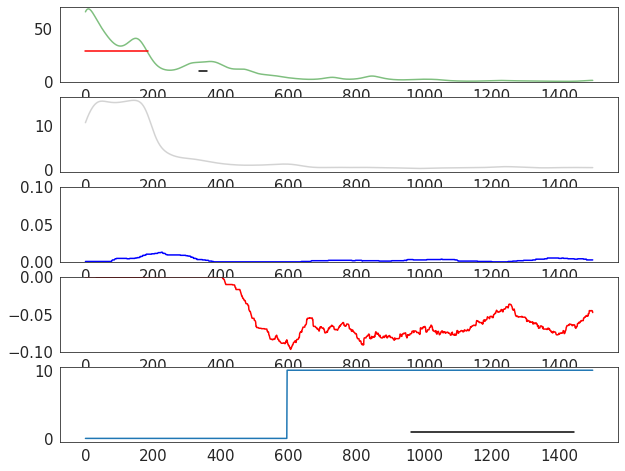

In [19]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,8),sharey=False)
chrom = 'chrVIII'
start=len(chip_fold[chip_fold.chr==chrom])-1500
end=len(chip_fold[chip_fold.chr==chrom])
axes[0].plot(np.arange(0, 1500), chip_foldaF[chip_foldaF.chr==chrom].fold_nolog_nosmooth[start:end][::-1], 'green',alpha = 0.5)
axes[0].plot([562643-562457,562643-562643],[29,29],'r')
axes[0].plot([360,337],[10,10],'k')
axes[0].set_ylim([0,70])
axes[1].plot(np.arange(0, 1500), DRIP_fold[DRIP_fold.chr==chrom].fold_nolog[start:end][::-1], 'darkgrey',alpha = 0.5)
axes[3].plot(np.arange(0, 1500),-(RNAseqaF[RNAseqaF.chr==chrom].fwd[start:end][::-1]),'red')
axes[2].plot(np.arange(0, 1500),(RNAseqaF[RNAseqaF.chr==chrom].rev[start:end][::-1]),'blue')
axes[2].set_ylim([0,0.1])
axes[3].set_ylim([-0.1,0])
axes[4].plot(np.arange(0, 1500), yeastgenome_gene_representation[chrom][0,start:end][::-1])
axes[4].plot([562643-561199,562643-561681],[1,1],'k')

### Fig. 7E and supplement 1G

In [20]:
DRIP_cumsum = {}
for chrom in chr_lengths.chromosome:
    DRIP_cumsum[chrom] = np.cumsum(DRIP_fold[DRIP_fold.chr==chrom].fold_nolog.values)

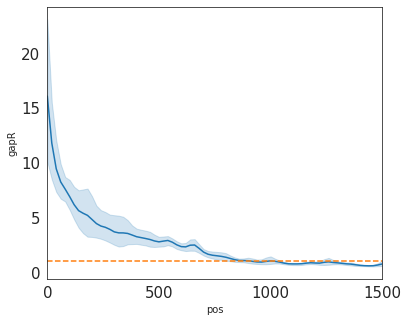

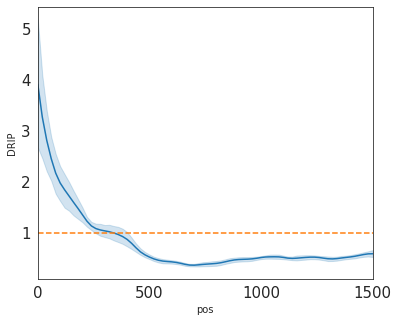

In [21]:
#GapR occupancy vs S1-DRIP-seq at telos -- only telos with Y elements
gapR_fold_nolog_cumsum = calccumsumtelos(chip_foldaF)

#GapR occupancy vs S1-DRIP-seq at telos
DRIP_occupancy = []
gapR_occupancy = []
bins = {}
for i in range(0,16):
    chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI'] #break up -- with Y elements DRIP, remove TR
    chrom = 'chr' + chroms[i]
    if chrom in ['chrII','chrV','chrVI','chrVIII','chrIX','chrX','chrXII','chrXIII','chrXIV','chrXVI']:
        start = []
        if chrom in ['chrVIII','chrIX','chrX','chrXII','chrXIII']:
            if chrom == 'chrVIII':
                start = 34
            elif chrom == 'chrIX':
                start = 77
            elif chrom == 'chrX':
                start = 60
            elif chrom == 'chrXII':
                start = 75
            elif chrom == 'chrXIII':
                start = 51
        else:
            start = DRIP_wt[DRIP_wt.chr==chrom].pos.values[0]
        x = np.arange(start,1521+start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a)
        gapR_occupancy.append(c)

    if chrom in ['chrIV','chrV','chrVII','chrVIII','chrXII','chrXV','chrXVI']:
        start = []
        if chrom in ['chrVIII','chrXIV']:
            if chrom == 'chrVIII':
                start = 562457
            elif chrom == 'chrXV':
                start = 1091274
        else:
            start = DRIP_wt[DRIP_wt.chr==chrom].pos.values[-1]
        x = np.arange(start-1521,start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a[::-1])
        gapR_occupancy.append(c[::-1])

drip_oc = np.asarray(DRIP_occupancy)/20
drip_avg = np.mean(drip_oc, axis = 0)
drip_avg_norm = drip_avg/np.max(drip_avg)
gapR_oc = np.asarray(gapR_occupancy)/20
gapR_avg = np.mean(gapR_oc, axis = 0)
gapR_avg_norm = gapR_avg/np.max(gapR_avg)

GapR_telo_matrix = pd.DataFrame([gapR_oc[0],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
GapR_telo_matrix['rep'] = 0
for i in range(1,len(gapR_oc)):
    t = pd.DataFrame([gapR_oc[i],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
    t['rep']=i
    GapR_telo_matrix = GapR_telo_matrix.append(t)
GapR_telo_matrix['norm'] = GapR_telo_matrix.gapR/np.mean(GapR_telo_matrix.gapR)

DRIP_telo_matrix = pd.DataFrame([drip_oc[0],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
DRIP_telo_matrix['rep'] = 0
for i in range(1,len(drip_oc)):
    t = pd.DataFrame([drip_oc[i],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
    t['rep']=i
    DRIP_telo_matrix = DRIP_telo_matrix.append(t)
DRIP_telo_matrix['norm'] = DRIP_telo_matrix.DRIP/np.mean(DRIP_telo_matrix.DRIP)

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="gapR", data=GapR_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="DRIP", data=DRIP_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

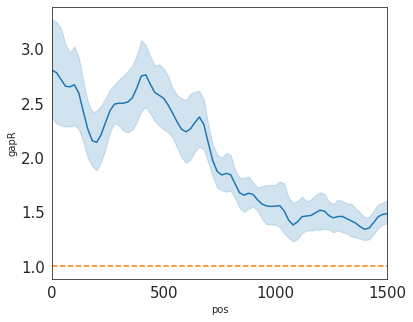

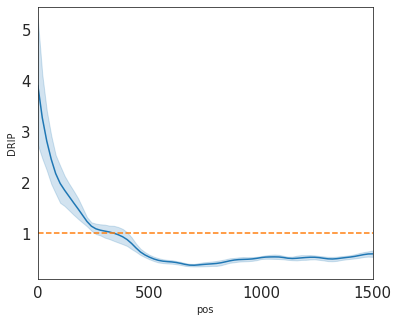

In [22]:
#GapR occupancy vs S1-DRIP-seq at telos -- only telos with Y elements -- supplement 1G
gapR_fold_nolog_cumsum = calccumsumtelos(chip_fold)

#GapR occupancy vs S1-DRIP-seq at telos
DRIP_occupancy = []
gapR_occupancy = []
bins = {}
for i in range(0,16):
    chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI'] #break up -- with Y elements DRIP, remove TR
    chrom = 'chr' + chroms[i]
    if chrom in ['chrII','chrV','chrVI','chrVIII','chrIX','chrX','chrXII','chrXIII','chrXIV','chrXVI']:
        start = []
        if chrom in ['chrVIII','chrIX','chrX','chrXII','chrXIII']:
            if chrom == 'chrVIII':
                start = 34
            elif chrom == 'chrIX':
                start = 77
            elif chrom == 'chrX':
                start = 60
            elif chrom == 'chrXII':
                start = 75
            elif chrom == 'chrXIII':
                start = 51
        else:
            start = DRIP_wt[DRIP_wt.chr==chrom].pos.values[0]
        x = np.arange(start,1521+start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a)
        gapR_occupancy.append(c)

    if chrom in ['chrIV','chrV','chrVII','chrVIII','chrXII','chrXV','chrXVI']:
        start = []
        if chrom in ['chrVIII','chrXIV']:
            if chrom == 'chrVIII':
                start = 562457
            elif chrom == 'chrXV':
                start = 1091274
        else:
            start = DRIP_wt[DRIP_wt.chr==chrom].pos.values[-1]
        x = np.arange(start-1521,start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a[::-1])
        gapR_occupancy.append(c[::-1])

drip_oc = np.asarray(DRIP_occupancy)/20
drip_avg = np.mean(drip_oc, axis = 0)
drip_avg_norm = drip_avg/np.max(drip_avg)
gapR_oc = np.asarray(gapR_occupancy)/20
gapR_avg = np.mean(gapR_oc, axis = 0)
gapR_avg_norm = gapR_avg/np.max(gapR_avg)

GapR_telo_matrix = pd.DataFrame([gapR_oc[0],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
GapR_telo_matrix['rep'] = 0
for i in range(1,len(gapR_oc)):
    t = pd.DataFrame([gapR_oc[i],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
    t['rep']=i
    GapR_telo_matrix = GapR_telo_matrix.append(t)
GapR_telo_matrix['norm'] = GapR_telo_matrix.gapR/np.mean(GapR_telo_matrix.gapR)

DRIP_telo_matrix = pd.DataFrame([drip_oc[0],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
DRIP_telo_matrix['rep'] = 0
for i in range(1,len(drip_oc)):
    t = pd.DataFrame([drip_oc[i],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
    t['rep']=i
    DRIP_telo_matrix = DRIP_telo_matrix.append(t)
DRIP_telo_matrix['norm'] = DRIP_telo_matrix.DRIP/np.mean(DRIP_telo_matrix.DRIP)

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="gapR", data=GapR_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="DRIP", data=DRIP_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

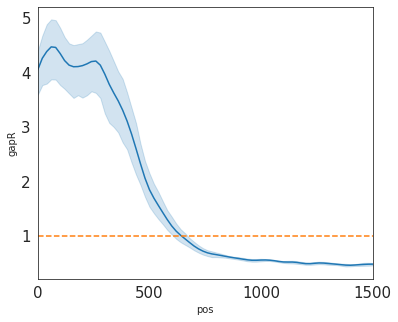

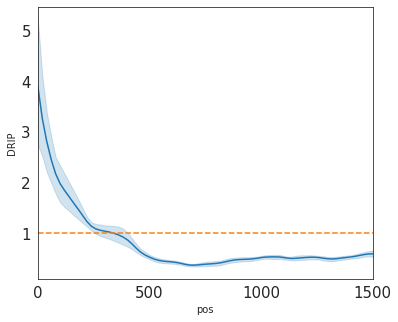

In [23]:
#GapR occupancy vs S1-DRIP-seq at telos -- only telos with Y elements -- supplement 1G
gapR_fold_nolog_cumsum = calccumsumtelos(chip_foldgly)

#GapR occupancy vs S1-DRIP-seq at telos
DRIP_occupancy = []
gapR_occupancy = []
bins = {}
for i in range(0,16):
    chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI'] #break up -- with Y elements DRIP, remove TR
    chrom = 'chr' + chroms[i]
    if chrom in ['chrII','chrV','chrVI','chrVIII','chrIX','chrX','chrXII','chrXIII','chrXIV','chrXVI']:
        start = []
        if chrom in ['chrVIII','chrIX','chrX','chrXII','chrXIII']:
            if chrom == 'chrVIII':
                start = 34
            elif chrom == 'chrIX':
                start = 77
            elif chrom == 'chrX':
                start = 60
            elif chrom == 'chrXII':
                start = 75
            elif chrom == 'chrXIII':
                start = 51
        else:
            start = DRIP_wt[DRIP_wt.chr==chrom].pos.values[0]
        x = np.arange(start,1521+start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a)
        gapR_occupancy.append(c)

    if chrom in ['chrIV','chrV','chrVII','chrVIII','chrXII','chrXV','chrXVI']:
        start = []
        if chrom in ['chrVIII','chrXIV']:
            if chrom == 'chrVIII':
                start = 562457
            elif chrom == 'chrXV':
                start = 1091274
        else:
            start = DRIP_wt[DRIP_wt.chr==chrom].pos.values[-1]
        x = np.arange(start-1521,start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a[::-1])
        gapR_occupancy.append(c[::-1])

drip_oc = np.asarray(DRIP_occupancy)/20
drip_avg = np.mean(drip_oc, axis = 0)
drip_avg_norm = drip_avg/np.max(drip_avg)
gapR_oc = np.asarray(gapR_occupancy)/20
gapR_avg = np.mean(gapR_oc, axis = 0)
gapR_avg_norm = gapR_avg/np.max(gapR_avg)

GapR_telo_matrix = pd.DataFrame([gapR_oc[0],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
GapR_telo_matrix['rep'] = 0
for i in range(1,len(gapR_oc)):
    t = pd.DataFrame([gapR_oc[i],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
    t['rep']=i
    GapR_telo_matrix = GapR_telo_matrix.append(t)
GapR_telo_matrix['norm'] = GapR_telo_matrix.gapR/np.mean(GapR_telo_matrix.gapR)

DRIP_telo_matrix = pd.DataFrame([drip_oc[0],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
DRIP_telo_matrix['rep'] = 0
for i in range(1,len(drip_oc)):
    t = pd.DataFrame([drip_oc[i],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
    t['rep']=i
    DRIP_telo_matrix = DRIP_telo_matrix.append(t)
DRIP_telo_matrix['norm'] = DRIP_telo_matrix.DRIP/np.mean(DRIP_telo_matrix.DRIP)

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="gapR", data=GapR_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="DRIP", data=DRIP_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

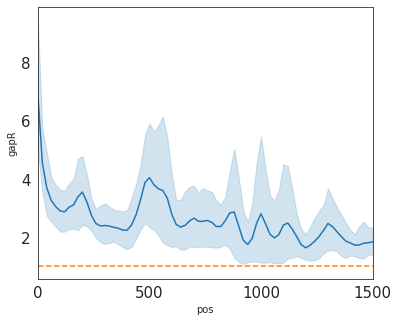

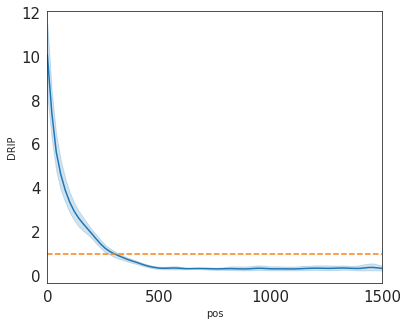

In [24]:
#GapR occupancy vs S1-DRIP-seq at telos -- only telos WITHOUT Y elements -- supplement 1G
gapR_fold_nolog_cumsum = calccumsumtelos(chip_foldaF)

DRIP_occupancy = []
gapR_occupancy = []
bins = {}
for i in range(0,16):
    chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI'] #break up -- no Y elements DRIP, remove TR
    chrom = 'chr' + chroms[i]
    start = []
    if chrom in ['chrI','chrIII','chrIV','chrVII','chrXI','chrXV']:
        if chrom == 'chrI':
            start = 62
        elif chrom == 'chrIII':
            start = 360
        elif chrom == 'chrIV':
            start = 154
        elif chrom == 'chrVII':
            start = 34
        elif chrom == 'chrXI':
            start = 67
        elif chrom == 'chrXV':
            start = 117
        x = np.arange(start,1521+start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a)
        gapR_occupancy.append(c)
    
    start = []
    if chrom in ['chrI','chrII','chrIII','chrVI','chrIX','chrX','chrXI','chrXIII','chrXIV']:
        if chrom == 'chrI':
            start = 230121
        elif chrom == 'chrII':
            start = 813138
        elif chrom == 'chrIII':
            start = 316522
        elif chrom == 'chrVI':
            start = 270113
        elif chrom == 'chrIX':
            start = 439816
        elif chrom == 'chrX':
            start = 745663
        elif chrom == 'chrXI':
            start = 666609
        elif chrom == 'chrXIII':
            start = 924307
        elif chrom == 'chrXIV':
            start = 784038
        x = np.arange(start-1521,start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a[::-1])
        gapR_occupancy.append(c[::-1])

drip_oc = np.asarray(DRIP_occupancy)/20
drip_avg = np.mean(drip_oc, axis = 0)
drip_avg_norm = drip_avg/np.max(drip_avg)
gapR_oc = np.asarray(gapR_occupancy)/20
gapR_avg = np.mean(gapR_oc, axis = 0)
gapR_avg_norm = gapR_avg/np.max(gapR_avg)

GapR_telo_matrix = pd.DataFrame([gapR_oc[0],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
GapR_telo_matrix['rep'] = 0
for i in range(1,len(gapR_oc)):
    t = pd.DataFrame([gapR_oc[i],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
    t['rep']=i
    GapR_telo_matrix = GapR_telo_matrix.append(t)
GapR_telo_matrix['norm'] = GapR_telo_matrix.gapR/np.mean(GapR_telo_matrix.gapR)

DRIP_telo_matrix = pd.DataFrame([drip_oc[0],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
DRIP_telo_matrix['rep'] = 0
for i in range(1,len(drip_oc)):
    t = pd.DataFrame([drip_oc[i],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
    t['rep']=i
    DRIP_telo_matrix = DRIP_telo_matrix.append(t)
DRIP_telo_matrix['norm'] = DRIP_telo_matrix.DRIP/np.mean(DRIP_telo_matrix.DRIP)

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="gapR", data=GapR_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="DRIP", data=DRIP_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

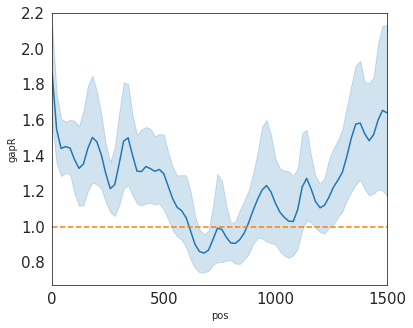

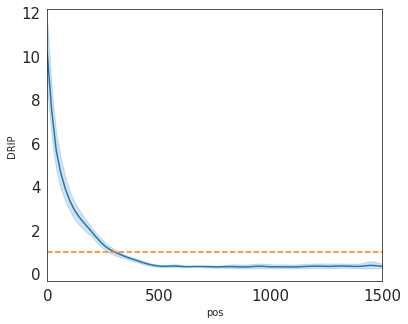

In [25]:
#GapR occupancy vs S1-DRIP-seq at telos -- only telos WITHOUT Y elements -- supplement 1G
gapR_fold_nolog_cumsum = calccumsumtelos(chip_fold)

DRIP_occupancy = []
gapR_occupancy = []
bins = {}
for i in range(0,16):
    chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI'] #break up -- no Y elements DRIP, remove TR
    chrom = 'chr' + chroms[i]
    start = []
    if chrom in ['chrI','chrIII','chrIV','chrVII','chrXI','chrXV']:
        if chrom == 'chrI':
            start = 62
        elif chrom == 'chrIII':
            start = 360
        elif chrom == 'chrIV':
            start = 154
        elif chrom == 'chrVII':
            start = 34
        elif chrom == 'chrXI':
            start = 67
        elif chrom == 'chrXV':
            start = 117
        x = np.arange(start,1521+start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a)
        gapR_occupancy.append(c)
    
    start = []
    if chrom in ['chrI','chrII','chrIII','chrVI','chrIX','chrX','chrXI','chrXIII','chrXIV']:
        if chrom == 'chrI':
            start = 230121
        elif chrom == 'chrII':
            start = 813138
        elif chrom == 'chrIII':
            start = 316522
        elif chrom == 'chrVI':
            start = 270113
        elif chrom == 'chrIX':
            start = 439816
        elif chrom == 'chrX':
            start = 745663
        elif chrom == 'chrXI':
            start = 666609
        elif chrom == 'chrXIII':
            start = 924307
        elif chrom == 'chrXIV':
            start = 784038
        x = np.arange(start-1521,start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a[::-1])
        gapR_occupancy.append(c[::-1])

drip_oc = np.asarray(DRIP_occupancy)/20
drip_avg = np.mean(drip_oc, axis = 0)
drip_avg_norm = drip_avg/np.max(drip_avg)
gapR_oc = np.asarray(gapR_occupancy)/20
gapR_avg = np.mean(gapR_oc, axis = 0)
gapR_avg_norm = gapR_avg/np.max(gapR_avg)

GapR_telo_matrix = pd.DataFrame([gapR_oc[0],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
GapR_telo_matrix['rep'] = 0
for i in range(1,len(gapR_oc)):
    t = pd.DataFrame([gapR_oc[i],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
    t['rep']=i
    GapR_telo_matrix = GapR_telo_matrix.append(t)
GapR_telo_matrix['norm'] = GapR_telo_matrix.gapR/np.mean(GapR_telo_matrix.gapR)

DRIP_telo_matrix = pd.DataFrame([drip_oc[0],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
DRIP_telo_matrix['rep'] = 0
for i in range(1,len(drip_oc)):
    t = pd.DataFrame([drip_oc[i],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
    t['rep']=i
    DRIP_telo_matrix = DRIP_telo_matrix.append(t)
DRIP_telo_matrix['norm'] = DRIP_telo_matrix.DRIP/np.mean(DRIP_telo_matrix.DRIP)

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="gapR", data=GapR_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="DRIP", data=DRIP_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

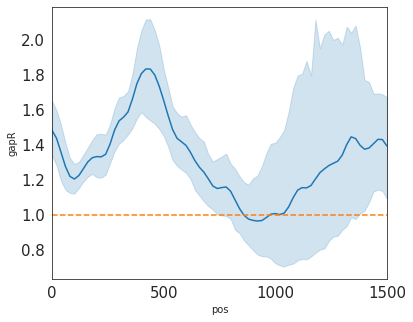

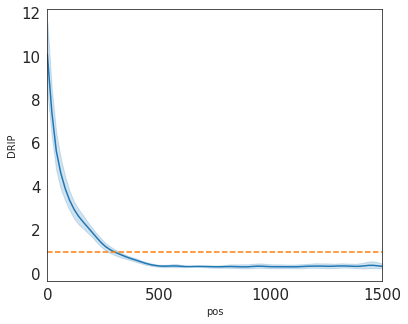

In [26]:
#GapR occupancy vs S1-DRIP-seq at telos -- only telos WITHOUT Y elements -- supplement 1G
gapR_fold_nolog_cumsum = calccumsumtelos(chip_foldgly)

DRIP_occupancy = []
gapR_occupancy = []
bins = {}
for i in range(0,16):
    chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI'] #break up -- no Y elements DRIP, remove TR
    chrom = 'chr' + chroms[i]
    start = []
    if chrom in ['chrI','chrIII','chrIV','chrVII','chrXI','chrXV']:
        if chrom == 'chrI':
            start = 62
        elif chrom == 'chrIII':
            start = 360
        elif chrom == 'chrIV':
            start = 154
        elif chrom == 'chrVII':
            start = 34
        elif chrom == 'chrXI':
            start = 67
        elif chrom == 'chrXV':
            start = 117
        x = np.arange(start,1521+start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a)
        gapR_occupancy.append(c)
    
    start = []
    if chrom in ['chrI','chrII','chrIII','chrVI','chrIX','chrX','chrXI','chrXIII','chrXIV']:
        if chrom == 'chrI':
            start = 230121
        elif chrom == 'chrII':
            start = 813138
        elif chrom == 'chrIII':
            start = 316522
        elif chrom == 'chrVI':
            start = 270113
        elif chrom == 'chrIX':
            start = 439816
        elif chrom == 'chrX':
            start = 745663
        elif chrom == 'chrXI':
            start = 666609
        elif chrom == 'chrXIII':
            start = 924307
        elif chrom == 'chrXIV':
            start = 784038
        x = np.arange(start-1521,start,20)
        a = np.zeros(76)
        c = np.zeros(76)
        for i in range(76):
            a[i]=DRIP_cumsum[chrom][x[i+1]]-DRIP_cumsum[chrom][x[i]]
            c[i]=gapR_fold_nolog_cumsum[chrom][x[i+1]]-gapR_fold_nolog_cumsum[chrom][x[i]]
        DRIP_occupancy.append(a[::-1])
        gapR_occupancy.append(c[::-1])

drip_oc = np.asarray(DRIP_occupancy)/20
drip_avg = np.mean(drip_oc, axis = 0)
drip_avg_norm = drip_avg/np.max(drip_avg)
gapR_oc = np.asarray(gapR_occupancy)/20
gapR_avg = np.mean(gapR_oc, axis = 0)
gapR_avg_norm = gapR_avg/np.max(gapR_avg)

GapR_telo_matrix = pd.DataFrame([gapR_oc[0],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
GapR_telo_matrix['rep'] = 0
for i in range(1,len(gapR_oc)):
    t = pd.DataFrame([gapR_oc[i],np.arange(len(gapR_oc[0]))],['gapR','pos']).transpose()
    t['rep']=i
    GapR_telo_matrix = GapR_telo_matrix.append(t)
GapR_telo_matrix['norm'] = GapR_telo_matrix.gapR/np.mean(GapR_telo_matrix.gapR)

DRIP_telo_matrix = pd.DataFrame([drip_oc[0],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
DRIP_telo_matrix['rep'] = 0
for i in range(1,len(drip_oc)):
    t = pd.DataFrame([drip_oc[i],np.arange(len(drip_oc[0]))],['DRIP','pos']).transpose()
    t['rep']=i
    DRIP_telo_matrix = DRIP_telo_matrix.append(t)
DRIP_telo_matrix['norm'] = DRIP_telo_matrix.DRIP/np.mean(DRIP_telo_matrix.DRIP)

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="gapR", data=GapR_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

plt.figure(figsize=(6,5))
sns.lineplot(x="pos", y="DRIP", data=DRIP_telo_matrix, ci=95)
plt.xticks([0,25,50,75],['0','500','1000','1500'])
plt.xlim([0,75])
plt.plot([0,1500],[1,1],'--')

### Fig. 7 - supplemental 1B

In [27]:
#pullout ARS sequences from genbank
yeastARS = {}
chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']
for i in range(1,10):
    x = loading_fasta_gbk(genome_folder + 'chr0{}.gb'.format(i),'genbank')
    yeastARS['chr'+chroms[i-1]] = extract_ars(x,['rep_origin'])
for i in range(10,17):
    x = loading_fasta_gbk(genome_folder + 'chr{}.gb'.format(i),'genbank')
    yeastARS['chr'+chroms[i-1]] = extract_ars(x,['rep_origin'])
    
ARS_df = pd.DataFrame([yeastARS['chrI'].name,yeastARS['chrI'].annotation,yeastARS['chrI'].start,yeastARS['chrI'].end,yeastARS['chrI'].strand]).transpose()
ARS_df.columns = ['name','descrip','start','end','strand']
ARS_df['chr'] = 'chrI'
for c in ['II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']:
    chrom = 'chr'+c
    x = pd.DataFrame([yeastARS[chrom].name,yeastARS[chrom].annotation,yeastARS[chrom].start,yeastARS[chrom].end,yeastARS[chrom].strand]).transpose()
    x.columns = ['name','descrip','start','end','strand']
    x['chr'] = chrom
    ARS_df = ARS_df.append(x)
ARS_df = ARS_df.reset_index().drop(columns='index')

In [28]:
fullstart = []
fullend = []
for i,value in ARS_df.iterrows():
    chrom = value.chr
    fullstart.append(value.start+la[chrom])
    fullend.append(value.end+la[chrom])
ARS_df['fullstart'] = fullstart
ARS_df['fullend'] = fullend

ARS_df['ARS_mean_gapR']=ARS_df.apply(lambda r:chip_fold.fold_nolog.loc[r['fullstart']:r['fullend']].mean(),axis=1)
ARS_df['ARS_mean_gapRaF']=ARS_df.apply(lambda r:chip_foldaF.fold_nolog.loc[r['fullstart']:r['fullend']].mean(),axis=1)
ARS_df['ARS_mean_gapRgly']=ARS_df.apply(lambda r:chip_foldaF.fold_nolog.loc[r['fullstart']:r['fullend']].mean(),axis=1)
ARS_df['ARS_length']=ARS_df.apply(lambda r:r['fullend']-r['fullstart'],axis=1)

RNAseq_RPKM['real_start']=RNAseq_RPKM[['fullstart','fullend']].min(axis=1)
RNAseq_RPKM['real_end']=RNAseq_RPKM[['fullstart','fullend']].max(axis=1)
RNAseq_RPKM['geneL'] = RNAseq_RPKM.apply(lambda r:r['real_end']-r['real_start'],axis=1)
high_exp = RNAseq_RPKM[['name','strand','chr','real_start','real_end','geneL','gal']]

df_regions = pd.concat([high_exp,high_exp.shift(-1)],axis=1,keys=['left','right'],names=['gene'])
df_regions.columns = ['{}_{}'.format(x,y) for x,y in df_regions.columns]
df_regions = df_regions.dropna(subset=['right_real_start'])
df_regions=df_regions.loc[df_regions['left_chr']==df_regions['right_chr']] #makes sure they're in the same chromosome!
df_regions.loc[df_regions['left_strand']==df_regions['right_strand'],'intergenic_type']='same'
df_regions.loc[(df_regions['left_strand']==1) & (df_regions['right_strand']==-1),'intergenic_type']='conv'
df_regions.loc[(df_regions['left_strand']==-1) & (df_regions['right_strand']==1),'intergenic_type']='div'

df_regions['intergenic_mean_gapR']=df_regions.apply(lambda r:chip_fold.fold_nolog.loc[r['left_real_end']:r['right_real_start']].mean(),axis=1)
df_regions['intergenic_mean_gapRaF']=df_regions.apply(lambda r:chip_foldaF.fold_nolog.loc[r['left_real_end']:r['right_real_start']].mean(),axis=1)
df_regions['intergenic_mean_gapRgly']=df_regions.apply(lambda r:chip_foldgly.fold_nolog.loc[r['left_real_end']:r['right_real_start']].mean(),axis=1)
df_regions['intergenic_length']=df_regions.apply(lambda r:r['right_real_start']-r['left_real_end'],axis=1)
df_final = df_regions[df_regions.intergenic_length >0]

Ttest_indResult(statistic=0.6367388821819138, pvalue=0.5243175143512073)
Ttest_indResult(statistic=10.0599292573946, pvalue=1.2393109148812972e-23)
Ttest_indResult(statistic=8.316099990624823, pvalue=1.098344559237956e-16)


(0, 5.800000000000001)

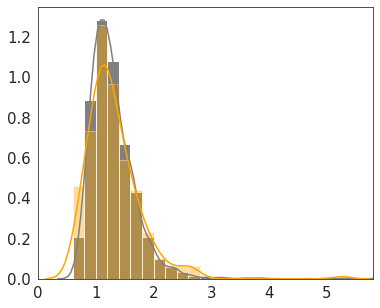

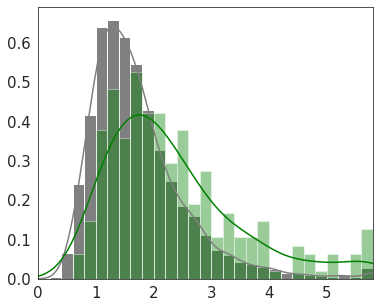

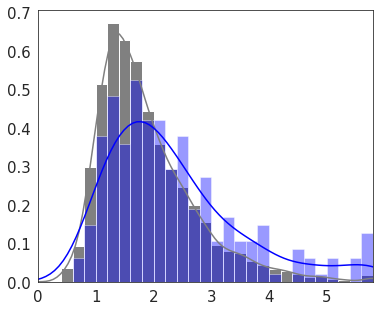

In [29]:
N=250
plt.figure(figsize=(6,5))
bins = np.arange(0,6,0.2)
sns.distplot(np.clip(np.array(df_final.intergenic_mean_gapR),bins[0],bins[-1]),bins=bins, color= 'grey',hist_kws={'alpha':1.0})
sns.distplot(np.clip(np.array(ARS_df[(ARS_df.fullend-ARS_df.fullstart <= N)].ARS_mean_gapR),bins[0],bins[-1]),bins=bins,color='orange')
plt.xlim([0,bins[-1]]) 
print(stats.ttest_ind(ARS_df[(ARS_df.fullend-ARS_df.fullstart <= N)].ARS_mean_gapR,df_final.intergenic_mean_gapR))

plt.figure(figsize=(6,5))
sns.distplot(np.clip(np.array(df_final.intergenic_mean_gapRaF),bins[0],bins[-1]),bins=bins, color= 'grey',hist_kws={'alpha':1.0})
sns.distplot(np.clip(np.array(ARS_df[(ARS_df.fullend-ARS_df.fullstart <= N)].ARS_mean_gapRaF),bins[0],bins[-1]),bins=bins,color='green')
print(stats.ttest_ind(ARS_df[(ARS_df.fullend-ARS_df.fullstart <= N)].ARS_mean_gapRaF,df_final.intergenic_mean_gapRaF))
plt.xlim([0,bins[-1]]) 

plt.figure(figsize=(6,5))
sns.distplot(np.clip(np.array(df_final.intergenic_mean_gapRgly),bins[0],bins[-1]),bins=bins, color= 'grey',hist_kws={'alpha':1.0})
sns.distplot(np.clip(np.array(ARS_df[(ARS_df.fullend-ARS_df.fullstart <= N)].ARS_mean_gapRgly),bins[0],bins[-1]),bins=bins,color='blue')
print(stats.ttest_ind(ARS_df[(ARS_df.fullend-ARS_df.fullstart <= N)].ARS_mean_gapRgly,df_final.intergenic_mean_gapRgly))
plt.xlim([0,bins[-1]]) 

### Fig. 7 - supplemental 1C

In [30]:
chip_diff = chip_foldgly.fold_nolog
n = 200

GapEnrich = []
GapEnrich2 = []
localrpkM = []
ind = []
for i, j in ARS_df.iterrows():
    try:
        m = []
        m = np.mean(RNAseqgly[j.fullstart-n:j.fullstart].fwd.values+RNAseqgly[j.fullend:j.fullend+n].rev.values)
        localrpkM.append(m)
        ind.append(i)
        if j.strand == 1:
            GapEnrich2.append(chip_diff[j.fullstart-500:j.fullstart+1000].values)
            GapEnrich.append(chip_diff[j.fullstart:j.fullend].max())
    except:
        print(i)

binSize = 10
out = []
errs = []
for j in range(len(GapEnrich2)):
    if len(GapEnrich2[j]) == 1500:
        a = []
        for i in range(0,1500,binSize):
            a.append(np.mean(GapEnrich2[j][i:i+10]))
        out.append(a)
    else:
        print(j)
        errs.append(j)
        
newMat = pd.DataFrame([localrpkM,GapEnrich,out,ind],['localrpkM','max_GapR','GapR_thrends','orig_ind']).transpose()
newMat.sort_values('max_GapR',ascending=False,inplace=True)

sortedGapEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.GapR_thrends)

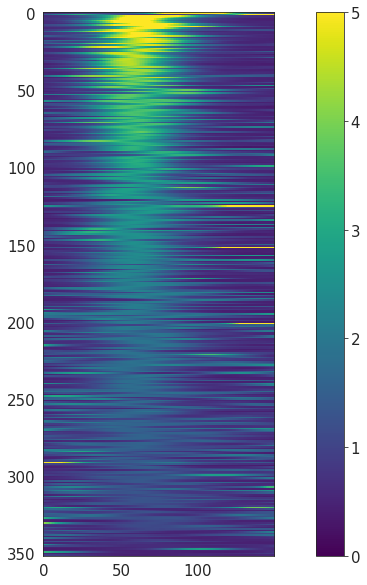

In [31]:
newMat = pd.DataFrame([localrpkM,GapEnrich,out,ind],['localrpkM','max_GapR','GapR_thrends','orig_ind']).transpose()
newMat.sort_values('max_GapR',ascending=False,inplace=True)

sortedGapEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.GapR_thrends)
    
plt.figure(figsize = [15,10])
plt.imshow(sortedGapEnrich,vmin=0,vmax=5,cmap='viridis')
plt.colorbar()

### Fig. 7 - supplemental 1D

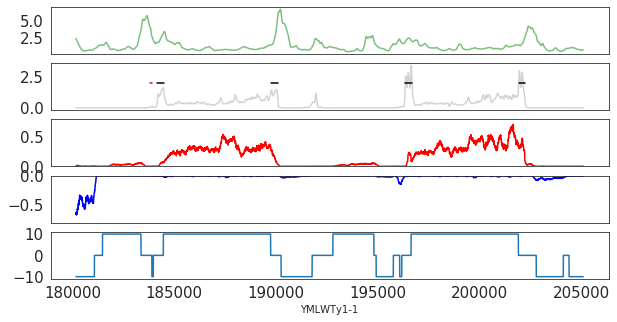

In [32]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,5),sharey=False)
i = 46 #i = 5, 10, 15, 18, 26 other good examples
chrom = ty_list.iloc[i].chr
startplot=ty_list.iloc[i].start-4000
endplot=ty_list.iloc[i].end+15000
axes[0].plot(np.arange(startplot, endplot), (chip_foldaF[chip_foldaF.chr==chrom].fold_nolog[startplot:endplot]), 'green',alpha = 0.5)
axes[1].plot(np.arange(startplot, endplot), DRIP_wt[DRIP_wt.chr==chrom].val_norm[startplot:endplot], 'darkgrey',alpha = 0.5)
axes[1].plot([183797,183887],[2,2],'r')
axes[1].plot([184170,184501],[2,2],'k')
axes[1].plot([189752,190083],[2,2],'k')
axes[1].plot([196332,196668 ],[2,2],'k')
axes[1].plot([201919,202234],[2,2],'k')
axes[2].plot(np.arange(startplot, endplot),(RNAseqaF[RNAseqaF.chr==chrom].fwd[startplot:endplot]),'red')
axes[3].plot(np.arange(startplot, endplot),-(RNAseqaF[RNAseqaF.chr==chrom].rev[startplot:endplot]),'blue')

axes[2].set_ylim([0,0.8])
axes[3].set_ylim([-0.8,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)
axes[4].set_xlabel(ty_list.iloc[i].names)

axes[4].plot(np.arange(startplot,endplot), yeastgenome_gene_representation[chrom][0,startplot:endplot])

### Fig. 7 - supplement 1F

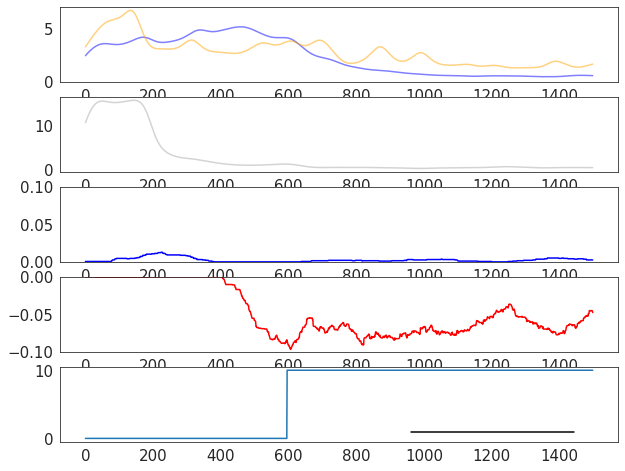

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,8),sharey=False)
chrom = 'chrVIII'
start=len(chip_fold[chip_fold.chr==chrom])-1500
end=len(chip_fold[chip_fold.chr==chrom])
axes[0].plot([562643-562457,562643-562643],[29,29],'r')
axes[0].plot([360,337],[10,10],'k')
axes[0].plot(np.arange(0, 1500), chip_foldgly[chip_foldgly.chr==chrom].fold_nolog_nosmooth[start:end][::-1], 'blue',alpha = 0.5)
axes[0].plot(np.arange(0, 1500), chip_fold[chip_fold.chr==chrom].fold_nolog_nosmooth[start:end][::-1], 'orange',alpha = 0.5)
axes[0].set_ylim([0,7])
axes[1].plot(np.arange(0, 1500), DRIP_fold[DRIP_fold.chr==chrom].fold_nolog[start:end][::-1], 'darkgrey',alpha = 0.5)
axes[3].plot(np.arange(0, 1500),-(RNAseqaF[RNAseqaF.chr==chrom].fwd[start:end][::-1]),'red')
axes[2].plot(np.arange(0, 1500),(RNAseqaF[RNAseqaF.chr==chrom].rev[start:end][::-1]),'blue')
axes[2].set_ylim([0,0.1])
axes[3].set_ylim([-0.1,0])
axes[4].plot(np.arange(0, 1500), yeastgenome_gene_representation[chrom][0,start:end][::-1])
axes[4].plot([562643-561199,562643-561681],[1,1],'k')

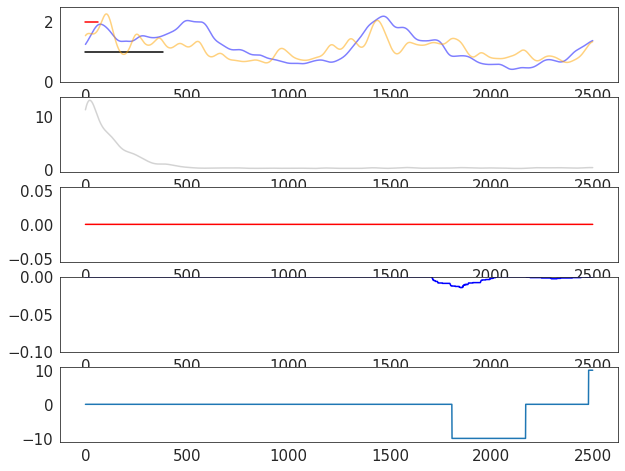

In [34]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,8),sharey=False)
chrom = 'chrI'
start=0
end=2500
axes[0].plot([0,62],[2,2],'r')
axes[0].plot([0,383],[1,1],'k')
axes[0].plot(np.arange(start, end), chip_foldgly[chip_foldgly.chr==chrom].fold_nolog_nosmooth[start:end], 'blue',alpha = 0.5)
axes[0].plot(np.arange(start, end), chip_fold[chip_fold.chr==chrom].fold_nolog_nosmooth[start:end], 'orange',alpha = 0.5)
axes[0].set_ylim([0,2.5])
axes[1].plot(np.arange(start, end), DRIP_fold[DRIP_fold.chr==chrom].fold_nolog[start:end], 'darkgrey',alpha = 0.5)

axes[2].plot(np.arange(start, end),(RNAseqaF[RNAseqaF.chr==chrom].fwd[start:end]),'red')
axes[3].plot(np.arange(start,end),-(RNAseqaF[RNAseqaF.chr==chrom].rev[start:end]),'blue')
axes[3].set_ylim([-0.1,0])
axes[4].plot(np.arange(start,end), yeastgenome_gene_representation[chrom][0,start:end])